In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
cd /content/drive/MyDrive/idle_robotics/

/content/drive/MyDrive/idle_robotics


In [16]:
# cd drive/MyDrive/idle_robotics/

In [17]:
!pip install rasterio
!pip install pyproj

In [ ]:
# !git clone https://github.com/magicleap/SuperGluePretrainedNetwork.git

fatal: destination path 'SuperGluePretrainedNetwork' already exists and is not an empty directory.


In [ ]:
# cd SuperGluePretrainedNetwork


/content/drive/MyDrive/idle_robotics/SuperGluePretrainedNetwork


In [ ]:
# !pip install -r requirements.txt

ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.17.61, 4.4.0.42, 4.4.0.44, 4.5.4.58, 4.5.5.62, 4.7.0.68
ERROR: Could not find a version that satisfies the requirement opencv-python==4.1.2.30 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84, 4.11.0.86, 4.12.0.88, 4.13.0.90)
ERROR: No matching distribution found for opencv-python==4.1.2.30


In [26]:
import importlib.util, sys

spec = importlib.util.spec_from_file_location(
    "utils",
    "/content/drive/MyDrive/idle_robotics/superpoint_cross_image_stitching/utils.py"
)
utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils)

print("Loaded utils:", dir(utils)[:10])

device: cuda
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
Loaded utils: ['SuperGlue', 'SuperPoint', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']


In [27]:
# !ls

In [61]:
import os
import cv2
import torch
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from pyproj import Transformer
from matplotlib import pyplot as plt
from SuperGluePretrainedNetwork.models.superpoint import SuperPoint
from SuperGluePretrainedNetwork.models.superglue import SuperGlue

# from superpoint_cross_image_stitching.utils import *
import sys
sys.path.insert(0, "/content/drive/MyDrive/idle_robotics/")
from superpoint_cross_image_stitching.utils import *

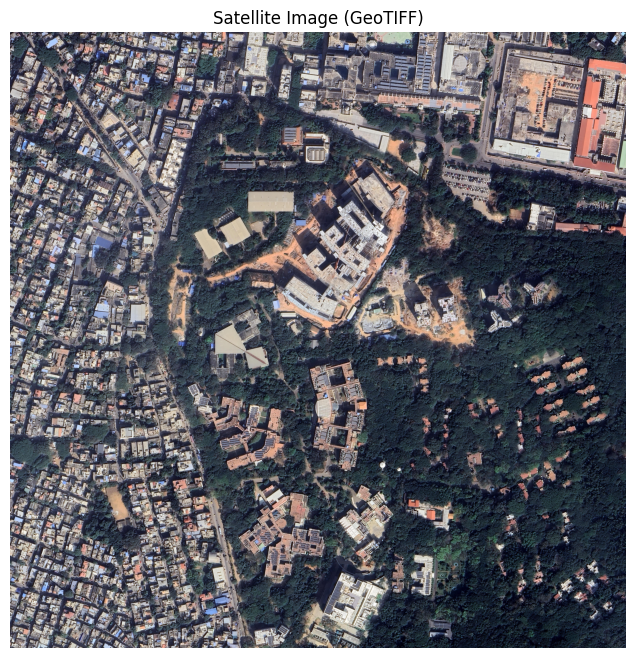

In [35]:
with rasterio.open("task_cv_model/map.tif") as src:
    src_crs = src.crs
    sat_img = src.read([1,2,3]).transpose(1,2,0)
    geo_transform = src.transform

to_wgs84 = Transformer.from_crs(
    src_crs, "EPSG:4326", always_xy=True
)

plt.figure(figsize=(8,8))
plt.imshow(sat_img)
plt.title("Satellite Image (GeoTIFF)")
plt.axis("off")
plt.show()


In [31]:
gt = pd.read_csv("task_cv_model/train_data/ground_truth.csv")
gt = gt.sort_values("timestamp").reset_index(drop=True)

# def align_timestamp(img_ts, gt_df):
#     idx = np.argmin(np.abs(gt_df["timestamp"].values - img_ts))
#     return gt_df.iloc[idx]

In [34]:
img_ts = 1445.599225344
matched = align_timestamp(img_ts, gt)

print("Image TS:", img_ts)
print("Matched GPS TS:", matched.timestamp)
print("Lat/Lon:", matched.latitude, matched.longitude)

Image TS: 1445.599225344
Matched GPS TS: 1445.530336832
Lat/Lon: 13.026782435813065 77.56334879668483


In [45]:
samples = []

for name in os.listdir("task_cv_model/train_data/drone_images"):
    ts = float(os.path.splitext(name)[0])
    gt_row = align_timestamp(ts, gt)

    samples.append({
        "path": os.path.join("task_cv_model/train_data/drone_images", name),
        "timestamp": ts,
        "lat": gt_row.latitude,
        "lon": gt_row.longitude
    })
train_set, val_set = train_test_split(
    samples, test_size=0.2, random_state=42
)

print("Train:", len(train_set), "Val:", len(val_set))


Train: 400 Val: 100


In [43]:
# Configure superpoint and superglue models
sp_config = {
    "descriptor_dim": 256,
    "nms_radius": 4,
    "keypoint_threshold": 0.001,
    "max_keypoints": 2048,
    "remove_borders": 4
}
sg_config = {
    "weights": "outdoor",
    "sinkhorn_iterations": 20,
    "match_threshold": 0.2
}
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)
superpoint = SuperPoint(sp_config).to(device).eval()
superglue = SuperGlue(sg_config).to(device).eval()

device: cuda
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [40]:
# def extract_superpoint(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     inp = torch.from_numpy(gray/255.).float()[None,None].to(device)

#     with torch.no_grad():
#         out = superpoint({"image": inp})

#     return (
#         out["keypoints"][0],
#         out["descriptors"][0],
#         out["scores"][0]
#     )


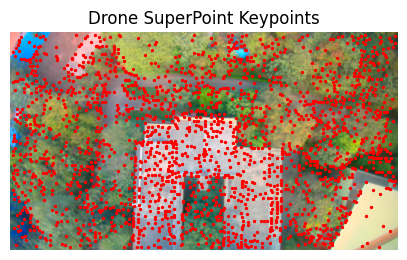

In [46]:
drone_img = cv2.imread(train_set[5]["path"])
kp, _, _ = extract_superpoint(drone_img)

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(drone_img, cv2.COLOR_BGR2RGB))
plt.scatter(kp[:,0].cpu(), kp[:,1].cpu(), s=2, c="r")
plt.title("Drone SuperPoint Keypoints")
os.makedirs('output', exist_ok=True)
plt.savefig('output/SuperPoint_Keypoints.png')
plt.axis("off")
plt.show()


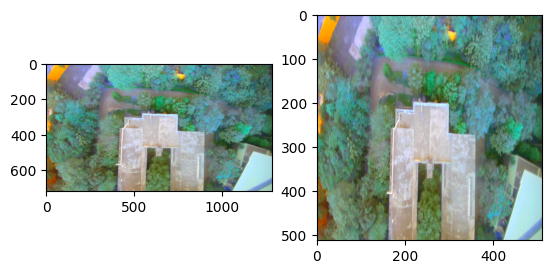

In [48]:
plt.subplot(121).imshow(drone_img)
drone_img_re = cv2.resize(drone_img, (512, 512))
plt.subplot(122).imshow(drone_img_re)

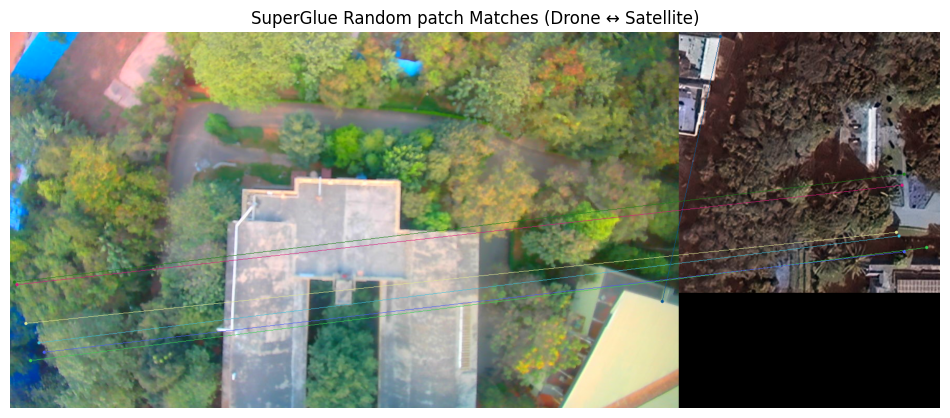

In [49]:
patch = sat_img[1000:1500, 2000:2500]
mk0, mk1 = superglue_match(drone_img, patch)
# mk0, mk1 = superglue_match(drone_img, patch)

vis = visualize_matches(drone_img, mk0, patch, mk1)

plt.figure(figsize=(12,5))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("SuperGlue Random patch Matches (Drone ↔ Satellite)")
plt.axis("off")
# plt.savefig('output/SuperPoint_Matches_random_patch.png')
plt.show()



In [ ]:
# kp2.shape

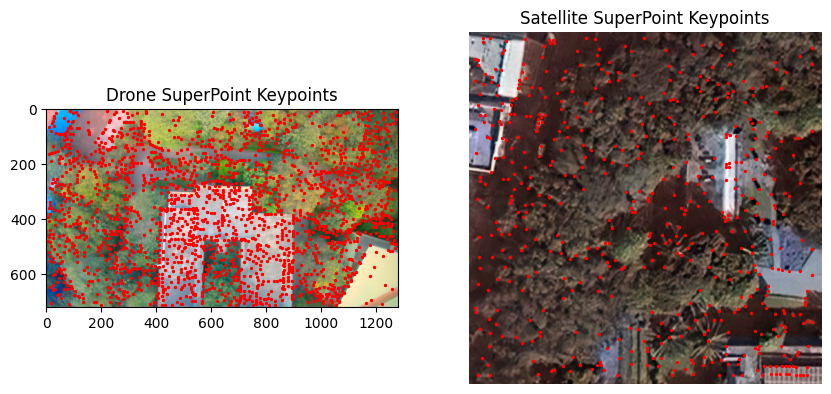

In [50]:
drone_img = cv2.imread(train_set[5]["path"])
kp, _, _ = extract_superpoint(drone_img)
ks, _, _ = extract_superpoint(patch)
# drone_img = cv2.resize(drone_img, (512, 512))
plt.figure(figsize=(10,10))
plt.subplot(121).imshow(cv2.cvtColor(drone_img, cv2.COLOR_BGR2RGB))
plt.subplot(121).scatter(kp[:,0].cpu(), kp[:,1].cpu(), s=2, c="r")
plt.title("Drone SuperPoint Keypoints")

plt.subplot(122).imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
plt.subplot(122).scatter(ks[:,0].cpu(),ks[:,1].cpu(), s=2, c="r")
plt.title("Satellite SuperPoint Keypoints")
os.makedirs('output', exist_ok=True)
# plt.savefig('output/SuperPoint_Keypoints_drone_sat.png')
plt.axis("off")
plt.show()

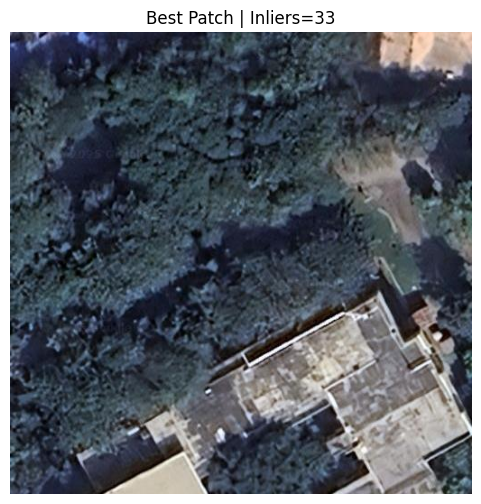

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(best["patch"])
plt.title(f"Best Patch | Inliers={best['inliers']}")
plt.axis("off")
plt.savefig('output/best_patch_satellite.png')
plt.show()

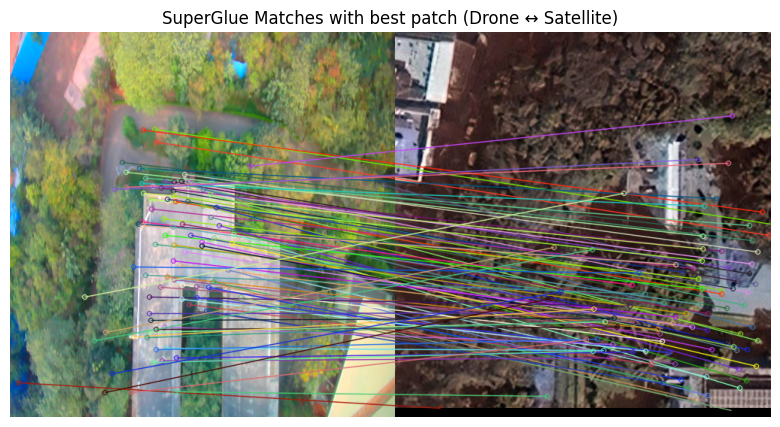

In [54]:
mk0, mk1 = superglue_match(drone_img, best['patch'])
kp1 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in mk0]
kp2 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in mk1]

matches = [cv2.DMatch(i, i, 0) for i in range(len(kp1))]

vis = cv2.drawMatches(
    drone_img, kp1,
    patch, kp2,
    matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.figure(figsize=(12,5))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("SuperGlue Matches with best patch (Drone ↔ Satellite)")
plt.axis("off")
# plt.savefig('output/SuperPoint_Matches_best_patch.png')
plt.show()

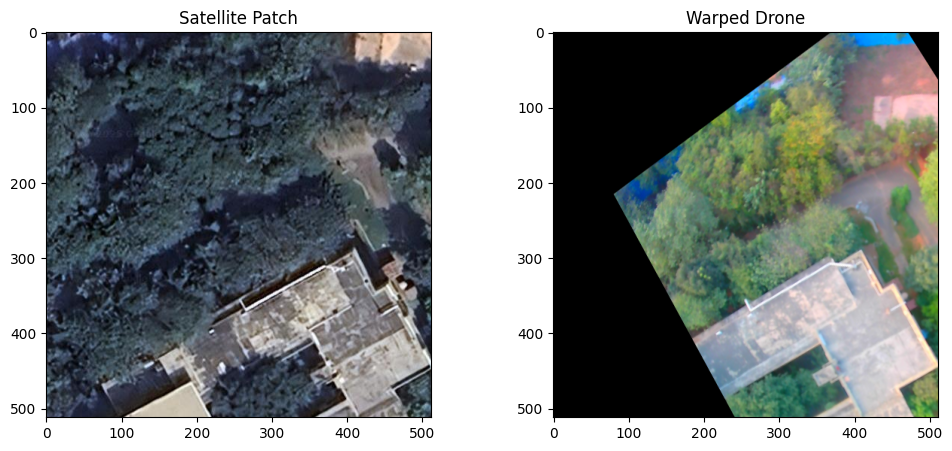

In [55]:
warped = cv2.warpPerspective(
    drone_img, best["H"],
    (best["patch"].shape[1], best["patch"].shape[0])
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(best["patch"])
plt.title("Satellite Patch")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Warped Drone")
# plt.savefig('output/Wrapped_drone_image.png')
plt.show()


In [ ]:
image_id = os.path.splitext(os.path.basename(train_set[0]["path"]))[0]
save_best_inlier_npz(best, "output_dir", image_id)

In [64]:
import os

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def pixel_to_latlon(px, py, transform, transformer):
    # Pixel → projected coordinates
    x_proj, y_proj = rasterio.transform.xy(
        transform, py, px, offset="center"
    )

    # Projected → lat/lon
    lon, lat = transformer.transform(x_proj, y_proj)
    return lat, lon

# def estimate_gps_from_inliers(best, geo_transform, transformer):
#     inliers = best["inlier_mask"]
#     pts = best["mk1"][inliers]

#     px = pts[:,0].mean() + best["x"]
#     py = pts[:,1].mean() + best["y"]

#     return pixel_to_latlon(px, py, geo_transform, transformer)


def estimate_gps_from_inliers(best, geo_transform, transformer):
    """
    Estimate GPS using centroid of satellite inlier points
    """
    mask = best["inlier_mask"]

    sat_pts = best["mk1"][mask]

    sat_pts = np.asarray(sat_pts)

    if sat_pts.ndim == 3:
        sat_pts = sat_pts.squeeze()

    if sat_pts.ndim != 2 or sat_pts.shape[1] != 2:
        print("Invalid sat_pts shape:", sat_pts.shape)
        return None

    if len(sat_pts) < 3:
        return None

    px = sat_pts[:, 0].mean() + best["x"]
    py = sat_pts[:, 1].mean() + best["y"]

    return pixel_to_latlon(px, py, geo_transform, transformer)

def visualize_gps_on_satellite(i,
    sat_img, px, py, patch_info=None, title="GPS estimate"
):
    plt.figure(figsize=(8,8))
    plt.imshow(sat_img)
    plt.scatter(px, py, c="red", s=60, marker="x", label="Estimated GPS")

    if patch_info is not None:
        x, y, w = patch_info
        rect = plt.Rectangle(
            (x, y), w, w,
            edgecolor="lime", facecolor="none", linewidth=2,
            label="Matched patch"
        )
        plt.gca().add_patch(rect)

    plt.legend()
    plt.title(title+f'_i')
    plt.axis("off")
    plt.show()
def save_gps_on_satellite(i,
    sat_img, px, py, best, out_dir
):
    ensure_dir(out_dir)

    vis = sat_img.copy()

    # GPS point
    cv2.drawMarker(
        vis,
        (int(px), int(py)),
        (0, 0, 255),
        markerType=cv2.MARKER_CROSS,
        markerSize=100,
        thickness=10
    )

    # Patch bounding box
    x, y = best["x"], best["y"]
    h, w = best["patch"].shape[:2]
    cv2.rectangle(
        vis,
        (x, y),
        (x + w, y + h),
        (0, 255, 0),
        20
    )

    cv2.imwrite(os.path.join(out_dir, f"gps_on_satellite_{i}.png"), vis)



In [65]:
def align_drone_to_satellite(drone_img, sat_img, path, i,vis = False):
    window = 512
    drone_img = cv2.resize(drone_img, (window, window))
    best = estimate_best_satellite_patch(drone_img, sat_img)
    image_id = os.path.splitext(os.path.basename(path))[0]
    save_best_inlier_npz(best, "output_dir", image_id)
    if best is None:
        return None

    h, w = drone_img.shape[:2]
    center = np.array([[w/2, h/2, 1]]).T
    mapped = best["H"] @ center
    mapped /= mapped[2]

    px = mapped[0] + best["x"]
    py = mapped[1] + best["y"]
    # print("mk1 shape:", best["mk1"].shape)
    # print("mask shape:", best["inlier_mask"].shape)
    # Inlier satellite points (pixel space)
    sat_inliers = best["mk1"][best["inlier_mask"]]

    px = sat_inliers[:,0].mean() + best["x"]
    py = sat_inliers[:,1].mean() + best["y"]

    # px = sat_pts[:,0].mean() + best["x"]
    # py = sat_pts[:,1].mean() + best["y"]

    if vis: visualize_gps_on_satellite(i,
        sat_img,
        px, py,
        patch_info=(best["x"], best["y"], best["patch"].shape[0]),
        title="Estimated GPS location on satellite"
    )
    out_dir = 'output'
    save_gps_on_satellite(i,sat_img, px, py, best, out_dir)
    lat, lon  = estimate_gps_from_inliers(
        best,
        geo_transform,
        to_wgs84
    )
    # return gps
    # lat, lon = estimate_gps_from_inliers
    # pixel_to_latlon(
    # px, py,
    # geo_transform,
    # to_wgs84
    # )
    return lat, lon


def haversine(lat1, lon1, lat2, lon2):
    R = 6371000
    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return 2*R*atan2(sqrt(a), sqrt(1-a))


In [68]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import time

def evaluate(dataset, desc="Evaluating", csv_path=None):
    errors = []
    times = []

    total = len(dataset)
    success = 0  # number of registered images

    # Threshold counters
    tp_5m = tp_20m = 0
    fn_5m = fn_20m = 0
    fp_5m = fp_20m = 0

    for i, sample in enumerate(tqdm(dataset, desc=desc, total=total)):
        drone = cv2.imread(sample["path"])
        basename = Path(sample["path"]).stem

        t0 = time.time()
        if i % 2 == 0:
            pred = align_drone_to_satellite(
                drone, sat_img, sample["path"], i, vis=True
            )
        else:
            pred = align_drone_to_satellite(
                drone, sat_img, sample["path"], i, vis=False
            )
        t1 = time.time()

        times.append(t1 - t0)

        if pred is None:
            record = {
                "image": basename,
                "status": "failed",
                "pred_lat": None,
                "pred_lon": None,
                "gt_lat": sample["lat"],
                "gt_lon": sample["lon"],
                "error_m": None
            }

            fn_5m += 1
            fn_20m += 1

        else:
            success += 1

            pred_lat = float(pred[0])
            pred_lon = float(pred[1])
            gt_lat = float(sample["lat"])
            gt_lon = float(sample["lon"])

            err = haversine(pred_lat, pred_lon, gt_lat, gt_lon)
            errors.append(err)

            # --- Threshold logic ---
            if err <= 5:
                tp_5m += 1
            else:
                fp_5m += 1

            if err <= 20:
                tp_20m += 1
            else:
                fp_20m += 1

            record = {
                "image": basename,
                "status": "success",
                "pred_lat": pred_lat,
                "pred_lon": pred_lon,
                "gt_lat": gt_lat,
                "gt_lon": gt_lon,
                "error_m": err
            }

        # Save incrementally
        if csv_path is not None:
            pd.DataFrame([record]).to_csv(
                csv_path,
                mode="a",
                header=not Path(csv_path).exists(),
                index=False
            )

    errors = np.array(errors)
    times = np.array(times)

    # --- Statistics ---
    mean_error = np.mean(errors)
    median_error = np.median(errors)
    rmse_error = np.sqrt(np.mean(errors ** 2))
    max_error = np.max(errors)

    err_std = np.std(errors)
    err_var = np.var(errors)

    recall_5m = 100 * tp_5m / total
    recall_20m = 100 * tp_20m / total

    precision_5m = 100 * tp_5m / max(success, 1)
    precision_20m = 100 * tp_20m / max(success, 1)

    registration_rate = 100 * success / total
    avg_time = times.mean()

    # --- Print ---
    print(f"Error Std Dev        : {err_std:.2f} m")
    print(f"Error Variance       : {err_var:.2f} m^2")

    print(f"Recall @ 5m          : {recall_5m:.2f}%")
    print(f"Recall @ 20m         : {recall_20m:.2f}%")

    print(f"Precision @ 5m       : {precision_5m:.2f}%")
    print(f"Precision @ 20m      : {precision_20m:.2f}%")

    print(f"Mean error           : {mean_error:.2f} m")
    print(f"Median error         : {median_error:.2f} m")
    print(f"RMSE                 : {rmse_error:.2f} m")
    print(f"Max error            : {max_error:.2f} m")

    print(f"Registration rate    : {registration_rate:.2f}%")
    print(f"Average time/image   : {avg_time:.3f} s")

    return {
        "mean": mean_error,
        "median": median_error,
        "rmse": rmse_error,
        "max": max_error,
        "recall_5m": recall_5m,
        "recall_20m": recall_20m,
        "precision_5m": precision_5m,
        "precision_20m": precision_20m,
        "registration_rate": registration_rate,
        "avg_time_sec": avg_time,
        "num_samples": success
    }



Train set:   0%|          | 0/6 [00:00<?, ?it/s]

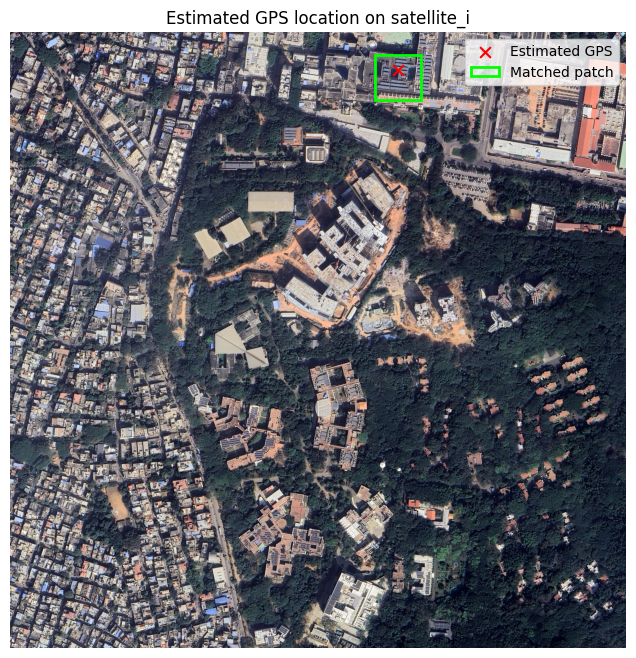

Train set:  33%|███▎      | 2/6 [01:17<02:32, 38.02s/it]

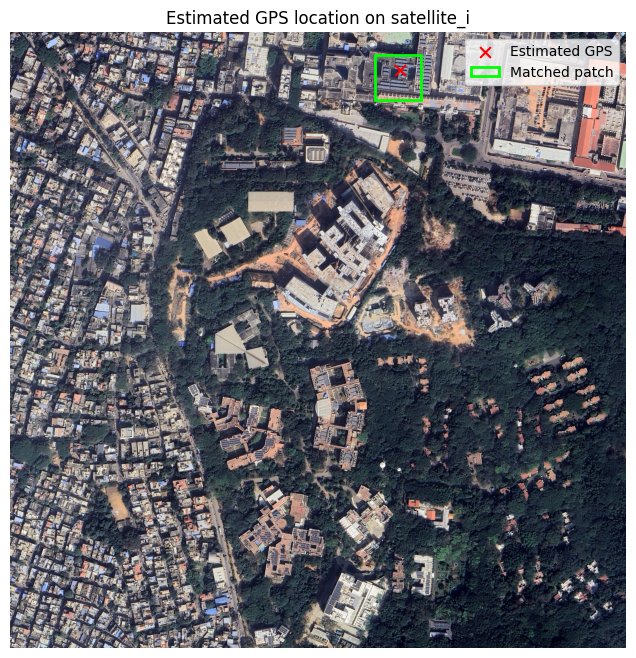

Train set:  67%|██████▋   | 4/6 [02:29<01:13, 36.63s/it]

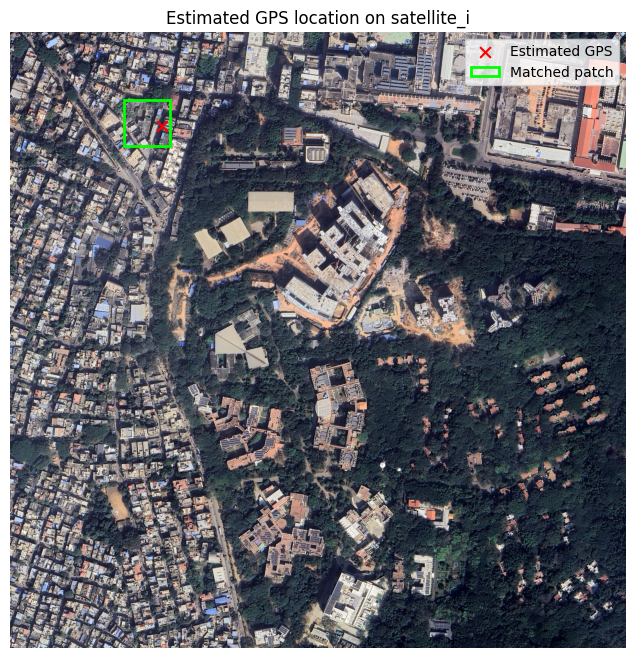

Train set: 100%|██████████| 6/6 [03:41<00:00, 36.98s/it]

Error Std Dev        : 76.44 m
Error Variance       : 5843.10 m^2
Recall @ 5m          : 0.00%
Recall @ 20m         : 0.00%
Precision @ 5m       : 0.00%
Precision @ 20m      : 0.00%
Mean error           : 418.07 m
Median error         : 469.57 m
RMSE                 : 425.00 m
Max error            : 471.96 m
Registration rate    : 100.00%
Average time/image   : 36.739 s


In [69]:
train_metrics = evaluate(
    samples[:6],
    desc="Train set",
    csv_path="train_try.csv"
)